In [65]:
from pyspark.ml.recommendation import ALS,ALSModel
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,UserDefinedFunction
from pyspark.sql.types import *
import pathlib
import numpy as np
import warnings
import math
import matplotlib.pyplot as plt
import re
warnings.filterwarnings('ignore')

In [2]:
#sc = SparkSession.builder.appName('als-recommender').getOrCreate()

In [3]:
sc = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "100g") \
    .config("spark.driver.memory", "100g") \
    .config("spark.executor.memory", "10g") \
    .config("spark.master", "local[16]") \
    .config("spark.local.dir","/home/bh_parijat/spark_temp/")\
    .getOrCreate()
# get spark context
#sc = spark.sparkContext

In [4]:
ratings_rdd  = sc.sparkContext.textFile('ml-1m/ratings.dat') \
                .map(lambda line: line.split("::")) \
                .map(lambda x: (int(x[0]),int(x[1]),int(x[2])))\
                .cache()

In [42]:
movies_rdd = sc.sparkContext.textFile('ml-1m/movies.dat')\
                .map(lambda line : line.split("::"))\
                .map(lambda x:(int(x[0]),x[1]))\
                .cache()

In [57]:
movies_rdd.take(2)

[(1, 'Toy Story (1995)'), (2, 'Jumanji (1995)')]

In [47]:
movies_schema = StructType([StructField('movieId',LongType(),True),StructField('name',StringType(),True)])

In [49]:
movies = sc.createDataFrame(movies_rdd,schema = schema)

In [68]:
get_names = lambda x: re.sub(r'\(\d{4}\)',"",x).rstrip().lower()

In [67]:

udf('Toy(1995)')

'toy'

In [53]:
#movies = movies.rdd.map(lambda x:(x[0],x[1])) )

In [54]:
ratings_rdd.take(2)



[(1, 1193, 5), (1, 661, 3)]

In [6]:
#ratings_rdd = ratings_rdd.sample(False,0.6)

In [7]:
schema = StructType([StructField('userId',LongType(),True),StructField('movieId',LongType(),True),StructField('rating',LongType(),True)])

In [8]:


ratings = sc.createDataFrame(ratings_rdd,schema=schema)

In [9]:
ratings.take(3)

[Row(userId=1, movieId=1193, rating=5),
 Row(userId=1, movieId=661, rating=3),
 Row(userId=1, movieId=914, rating=3)]

## Spilt data for training, validation and testing

In [10]:
train_data, validation_data, test_data = ratings.randomSplit([0.6,0.2,0.2],seed=90)

In [11]:

def model_train(train_data, validation_data, num_iters, ranks, regularizations):
    
    min_error = np.float('inf')
    
    best_rank = None
    
    best_model = None
    
    best_regularization = None
    
    for rank in ranks:
        
        for param in regularizations:
            
            model = ALS(rank=rank,maxIter=num_iters,regParam=param,userCol='userId',itemCol='movieId',nonnegative = True).fit(train_data)
            
            train =  train_data.select(['userId','movieId'])
            
            valid = validation_data.select(['userId','movieId'])
            
            
            
            predictions = model.transform(valid).fillna(0)
            
            
            cond = [predictions.userId == validation_data.userId, predictions.movieId == validation_data.movieId]
            temp = validation_data.join(predictions,cond).select(validation_data.rating, predictions.prediction)
            
            #print(temp.take(2))
            error = math.sqrt(temp.rdd.map(lambda x: (x[-1]-x[-2])**2).mean())
            
            if error<min_error:
                min_error = error
                best_rank = rank
                best_regularization = param
                best_model = model
            
            #avg_error = error.select("select avg()")
            #print(error.take(2),error.mean(),error.sum(),type(error),error.count())
            #print(predictions.take(2))
            
    return best_model,best_rank,best_regularization

In [12]:
model,rank,regular_param = model_train(train_data, validation_data, 10,range(8,22,2),[0.1,1,2,4])

## Best Hyperparameters

In [16]:
model.write().overwrite().save(str(pathlib.Path().absolute()/'model'))
print("rank is {} and regularization hyper-parameter is {}".format(rank,regular_param))

rank is 20 and regularization hyper-parameter is 0.1


## Get the learning curve

In [15]:
def get_training_curve(train,rank,regular_param, iterations):
    
    errors = []
    
    for num_iters in range(1,iterations):
        model = ALS(rank = rank, maxIter = num_iters, regParam = regular_param, userCol = 'userId', itemCol = 'movieId', nonnegative = True ).fit(train)

        predictions = model.transform(train).fillna(0)

        condition = [train.userId == predictions.userId,  train.movieId == predictions.movieId]

        error = predictions.join(train,condition).select(predictions.prediction,train.rating).rdd.map(lambda x: (x[0]-x[1])**2).mean()

        errors.append(math.sqrt(error))
        
        #print(predictions.schema)
        
        predictions.select(predictions.userId,predictions.movieId,predictions.prediction).withColumnRenamed("prediction","rating")
        
    return errors
    

In [17]:
errors = get_training_curve(train_data,rank=20,regular_param=0.1,iterations=11)

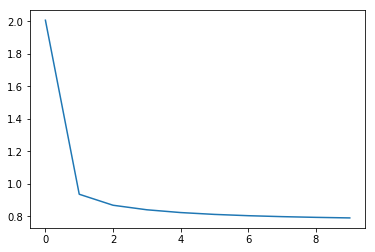

In [18]:
plt.plot(errors)

## The minimum training error

In [20]:
min(errors)

0.7909596187552549

In [38]:
test_predictions = ALSModel.read().load((str(pathlib.Path().absolute()/'model'))).transform(test_data).fillna(0)

In [39]:
test_error = math.sqrt(test_predictions.rdd.map(lambda x: (x.rating-x.prediction)**2).mean())

In [40]:
test_error

0.8744198541233533

In [ ]:
def get_ids(movies,fav_movies_names):
    
    movie_ids = movies.filter(lambda x :)